<a href="https://colab.research.google.com/github/Emma-Ok/Phishing-Detection-ML/blob/alc4dev/ModelsWithAllSamples/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Random Forest para Detección de Phishing
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV, 
    StratifiedKFold,
    cross_val_score
)
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    matthews_corrcoef
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# CARGA Y PREPARACIÓN DE DATOS

# Carga directa desde GitHub
url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"
df = pd.read_csv(url)
df = df.drop(columns=['id'])

# Separar X e y
X = df.drop(columns=['CLASS_LABEL'])
y = df['CLASS_LABEL']

print(f"Forma del dataset: {X.shape}")
print(f"Distribución de clases: {Counter(y)}")

# DIVISIÓN DEL DATASET (70-15-15)

print("\n🔄 Dividiendo dataset...")

# Primera división: 70% entrenamiento, 30% temporal
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

# Segunda división: 15% validación, 15% prueba
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Entrenamiento: {X_train.shape[0]} muestras")
print(f"Validación: {X_val.shape[0]} muestras") 
print(f"Prueba: {X_test.shape[0]} muestras")


Forma del dataset: (10000, 48)
Distribución de clases: Counter({1: 5000, 0: 5000})

🔄 Dividiendo dataset...
Entrenamiento: 7000 muestras
Validación: 1500 muestras
Prueba: 1500 muestras


In [5]:
param_dist_random = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.3, 0.5]
}

# Configuración de validación cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# BÚSQUEDA DE HIPERPARÁMETROS


# Modelo base
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
    
# Random Search con F1-score como métrica principal
search = RandomizedSearchCV(
        estimator=rf_base,
        param_distributions=param_dist_random,
        n_iter=50,  # 50 combinaciones aleatorias 
        cv=cv_strategy,
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
# Entrenamiento
search.fit(X_train, y_train)
    

print(f"\n✅ Mejores hiperparámetros encontrados:")
for param, value in search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n📈 Mejor F1-Score en validación cruzada: {search.best_score_:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Mejores hiperparámetros encontrados:
  n_estimators: 50
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: log2
  max_depth: 15

📈 Mejor F1-Score en validación cruzada: 0.9790


In [6]:
# Función para calcular las métricas de evaluación
def calculate_metrics(y_true, y_pred, y_proba, set_name):
    
    print(f"\n=== MÉTRICAS - {set_name.upper()} ===")
    
    # Métricas principales
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    
    # Métricas complementarias
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    print(f"Accuracy (Exactitud):     {accuracy:.4f}")
    print(f"Precision (Precisión):    {precision:.4f}")
    print(f"Recall (Sensibilidad):    {recall:.4f}")
    print(f"F1-Score:                 {f1:.4f}")
    print(f"AUC-ROC:                  {auc_roc:.4f}")
    print(f"Specificity (Especific.): {specificity:.4f}")
    print(f"MCC:                      {mcc:.4f}")
    
    return {
        'accuracy': accuracy, 'precision': precision, 'recall': recall,
        'f1_score': f1, 'auc_roc': auc_roc, 'specificity': specificity,
        'mcc': mcc
    }

In [7]:
# MODELO FINAL Y EVALUACIÓN

# Modelo con mejores hiperparámetros
best_rf = search.best_estimator_

# Entrenamiento en conjunto completo de entrenamiento
best_rf.fit(X_train, y_train)


# PREDICCIONES Y MÉTRICAS


# Predicciones en conjunto de validación
y_val_pred = best_rf.predict(X_val)
y_val_proba = best_rf.predict_proba(X_val)[:, 1]

# Predicciones en conjunto de prueba
y_test_pred = best_rf.predict(X_test)
y_test_proba = best_rf.predict_proba(X_test)[:, 1]

#  CÁLCULO DE MÉTRICAS PRINCIPALES

# Evaluación en validación y prueba
val_metrics = calculate_metrics(y_val, y_val_pred, y_val_proba, "Validación")
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_proba, "Prueba")


=== MÉTRICAS - VALIDACIÓN ===
Accuracy (Exactitud):     0.9880
Precision (Precisión):    0.9854
Recall (Sensibilidad):    0.9907
F1-Score:                 0.9880
AUC-ROC:                  0.9992
Specificity (Especific.): 0.9853
MCC:                      0.9760

=== MÉTRICAS - PRUEBA ===
Accuracy (Exactitud):     0.9820
Precision (Precisión):    0.9852
Recall (Sensibilidad):    0.9787
F1-Score:                 0.9819
AUC-ROC:                  0.9981
Specificity (Especific.): 0.9853
MCC:                      0.9640


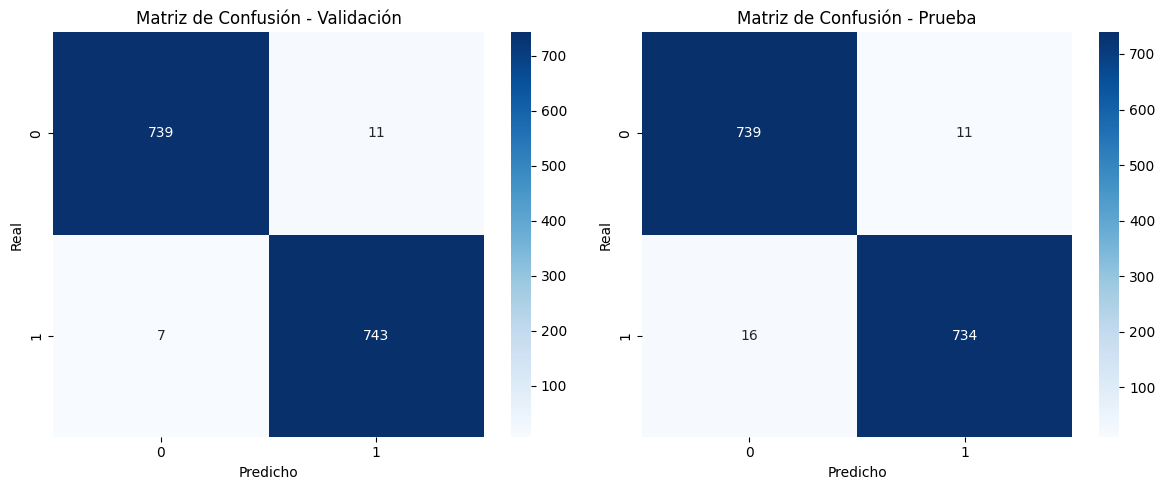

In [8]:
# MATRIZ DE CONFUSIÓN

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión - Validación
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Validación')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

# Matriz de confusión - Prueba
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Matriz de Confusión - Prueba')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

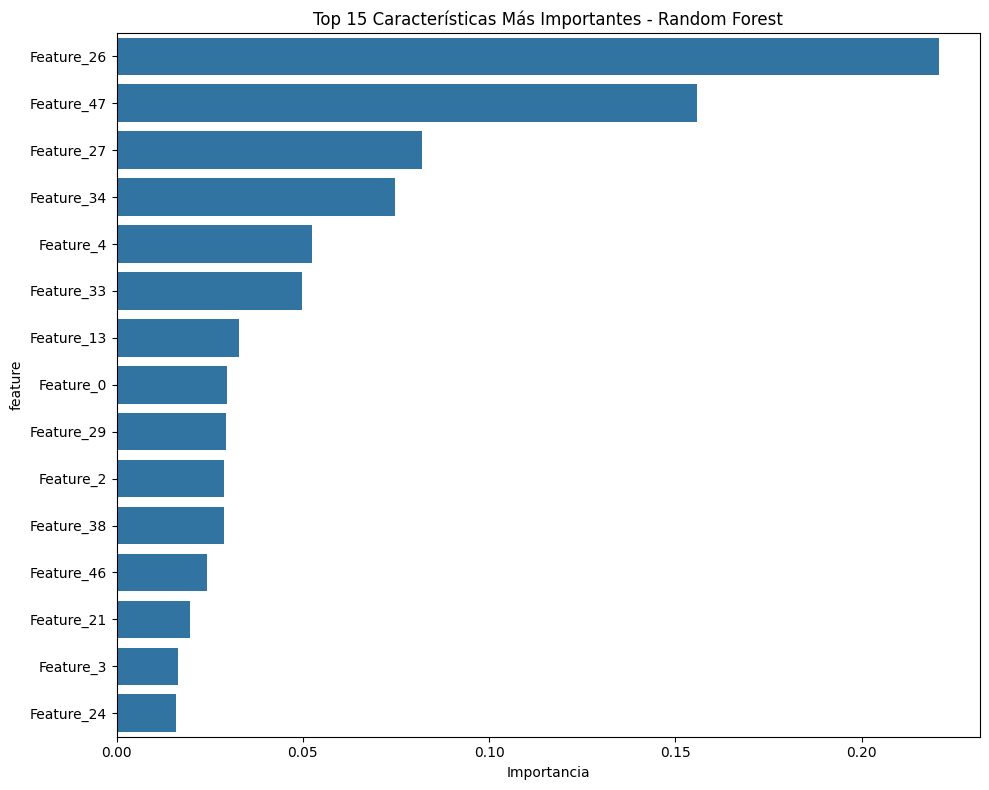

Top 10 Características:
 1. Feature_26: 0.2208
 2. Feature_47: 0.1559
 3. Feature_27: 0.0820
 4. Feature_34: 0.0748
 5. Feature_4: 0.0526
 6. Feature_33: 0.0497
 7. Feature_13: 0.0330
 8. Feature_0: 0.0297
 9. Feature_29: 0.0295
10. Feature_2: 0.0289


In [9]:
# IMPORTANCIA DE CARACTERÍSTICAS

# Obtener importancias
feature_importance = best_rf.feature_importances_
feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]

# Crear DataFrame para visualización
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Visualizar top 15 características más importantes
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('Top 15 Características Más Importantes - Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

print("Top 10 Características:")
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")


In [10]:
# VALIDACIÓN DE CRITERIOS DE SELECCIÓN

print("\n✅ VALIDACIÓN DE CRITERIOS DE SELECCIÓN:")
print("="*50)

# Criterio 1: F1-score maximizado
print(f"1. F1-Score Validación: {val_metrics['f1_score']:.4f}")

# Criterio 2: AUC-ROC ≥ 0.90
auc_threshold = 0.90
auc_check = "✓" if val_metrics['auc_roc'] >= auc_threshold else "✗"
print(f"2. AUC-ROC ≥ 0.90: {val_metrics['auc_roc']:.4f} {auc_check}")

# Criterio 3: Estabilidad entre validación y prueba
f1_diff = abs(val_metrics['f1_score'] - test_metrics['f1_score'])
stability_check = "✓" if f1_diff < 0.05 else "✗"
print(f"3. Estabilidad F1 (diff < 0.05): {f1_diff:.4f} {stability_check}")

# Criterio 4: Generalización adecuada
generalization_check = "✓" if test_metrics['f1_score'] > 0.80 else "✗"
print(f"4. Generalización (F1 > 0.80): {test_metrics['f1_score']:.4f} {generalization_check}")

# ========================================
# 11. RESUMEN FINAL
# ========================================

print("\n" + "="*60)
print("🎯 RESUMEN FINAL - RANDOM FOREST")
print("="*60)

print(f"Hiperparámetros Óptimos:")
for param, value in search.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\nRendimiento:")
print(f"  • F1-Score (Validación): {val_metrics['f1_score']:.4f}")
print(f"  • F1-Score (Prueba):     {test_metrics['f1_score']:.4f}")
print(f"  • AUC-ROC (Prueba):      {test_metrics['auc_roc']:.4f}")
print(f"  • Accuracy (Prueba):     {test_metrics['accuracy']:.4f}")

# Verificar si cumple todos los criterios
all_criteria = (
    val_metrics['auc_roc'] >= 0.90 and
    f1_diff < 0.05 and
    test_metrics['f1_score'] > 0.80
)

status = "APROBADO ✅" if all_criteria else "REVISAR ⚠️"
print(f"\nEstado del Modelo: {status}")

print("\n" + "="*60)


✅ VALIDACIÓN DE CRITERIOS DE SELECCIÓN:
1. F1-Score Validación: 0.9880
2. AUC-ROC ≥ 0.90: 0.9992 ✓
3. Estabilidad F1 (diff < 0.05): 0.0061 ✓
4. Generalización (F1 > 0.80): 0.9819 ✓

🎯 RESUMEN FINAL - RANDOM FOREST
Hiperparámetros Óptimos:
  • n_estimators: 50
  • min_samples_split: 2
  • min_samples_leaf: 1
  • max_features: log2
  • max_depth: 15

Rendimiento:
  • F1-Score (Validación): 0.9880
  • F1-Score (Prueba):     0.9819
  • AUC-ROC (Prueba):      0.9981
  • Accuracy (Prueba):     0.9820

Estado del Modelo: APROBADO ✅

